In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import patsy
import math
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest
import statistics

In [40]:
# Import city gini index data
gini_index_df = pd.read_csv('city_gini_index.csv', encoding='latin-1', header = 1)
# Drop the two ID columns which will not be used
gini_index_df = gini_index_df.drop(columns = ['Id', 'Id2'])

gini_index_df.head

<bound method NDFrame.head of                                               Geography  Estimate; Gini Index  \
0                    Abbeville, LA Urban Cluster (2010)                0.4608   
1                    Abbeville, SC Urban Cluster (2010)                0.5020   
2                   Abbotsford, WI Urban Cluster (2010)                0.4354   
3                     Aberdeen, MS Urban Cluster (2010)                0.4603   
4                     Aberdeen, SD Urban Cluster (2010)                0.4565   
5                     Aberdeen, WA Urban Cluster (2010)                0.4571   
6     Aberdeen--Bel Air South--Bel Air North, MD Urb...                0.4125   
7                    Abernathy, TX Urban Cluster (2010)                0.3990   
8                      Abilene, KS Urban Cluster (2010)                0.4300   
9                     Abilene, TX Urbanized Area (2010)                0.4558   
10                    Abingdon, IL Urban Cluster (2010)                0.3890  

In [3]:
newcol = []
# Loop through the gini index dataframe and convert the state name to its abbreviation
for citystate in gini_index_df.iterrows():
    strcity = str(citystate[1][0])
    
    # Get the city name
    city = strcity.split(',')[0].strip()
    splitcity = city.split('--')
    if (len(splitcity) > 1):
        city = splitcity[1]
    else:
        city = splitcity[0]
    state = strcity.split(',')[1].strip()
    newstate = state.split(' ')[0]
    newcol.append(city + ', ' + newstate)

# Replace the old county and state name column with the new county and abbreviated state column
gini_index_df['place_state'] = newcol
gini_index_df.drop(columns = ['Geography'], inplace = True)
gini_index_df.shape

(3573, 3)

In [4]:
outliersgini=[]
indexesgini = []
threshold=3
mean_gini = np.mean(gini_index_df['Estimate; Gini Index'])
std_gini =np.std(gini_index_df['Estimate; Gini Index'])

for i in gini_index_df.iterrows():
    gini = i[1][0]
    indexgini = i[0]
    z_scoregini= (gini - mean_gini)/std_gini 
    if np.abs(z_scoregini) > threshold:
        outliersgini.append(gini)
        indexesgini.append(indexgini)
print(len(indexesgini))

25


In [5]:
gini_index_df.drop(index=indexesgini, inplace = True)
gini_index_df.shape

(3548, 3)

In [6]:
# Load the county crime data
df_crime = pd.read_csv('UScrime_scraped.csv')
df_crime = df_crime.drop(['Unnamed: 0'], axis = 1)
df_crime.shape

(9865, 19)

In [7]:
# Dictionary used to convert the state name to its abbreviation
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'District of Columbia',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}

newcol = []
# Loop through the gini index dataframe and convert the state name to its abbreviation
for strstate in df_crime.iterrows():
    # Get the county and state name
    currstate = str(strstate[1][1])

    # Search through the dictionary for the state name and change it to its abbreviation
    for state, stateabbrev in us_state_abbrev.items():
        if currstate == state:
            newcol.append(stateabbrev)

# Replace the old county and state name column with the new county and abbreviated state column
df_crime['abbrev_state'] = newcol
df_crime['place_state'] = df_crime['city'] + ', ' + df_crime['abbrev_state']
df_crime.drop(columns = ['city', 'state', 'abbrev_state'], inplace = True)
df_crime.head()

,murders,murdersper100k,rapes,rapesper100k,robberies,robberiesper100k,assaults,assaultsper100k,burglaries,burglariesper100k,thefts,theftsper100k,autothefts,autotheftsper100k,arson,arsonper100k,crime index,place_state
0,0.0,0.0,2.0,77.2,0.0,0.0,10.0,386.1,13.0,501.9,47.0,1814.7,6.0,231.7,NaN,NaN,265.3,"Abbeville, AL"
1,1.0,23.1,1.0,23.1,6.0,138.4,17.0,392.2,42.0,969.1,204.0,4707.0,15.0,346.1,NaN,NaN,468.4,"Adamsville, AL"
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,135.5,1.0,135.5,11.0,1490.5,2.0,271.0,NaN,NaN,117.9,"Addison, AL"
3,0.0,0.0,0.0,0.0,5.0,15.0,69.0,207.5,44.0,132.3,462.0,1389.3,21.0,63.2,NaN,NaN,115.9,"Alabaster, AL"
4,0.0,0.0,7.0,32.4,7.0,32.4,8.0,37.1,145.0,671.7,413.0,1913.1,90.0,416.9,NaN,NaN,200.0,"Albertville, AL"


In [8]:
list(df_crime.columns)

['murders',
 'murdersper100k',
 'rapes',
 'rapesper100k',
 'robberies',
 'robberiesper100k',
 'assaults',
 'assaultsper100k',
 'burglaries',
 'burglariesper100k',
 'thefts',
 'theftsper100k',
 'autothefts',
 'autotheftsper100k',
 'arson',
 'arsonper100k',
 'crime index',
 'place_state']

In [9]:
df_crime = df_crime[['crime index', 'place_state','murders',
 'murdersper100k',
 'rapes',
 'rapesper100k',
 'robberies',
 'robberiesper100k',
 'assaults',
 'assaultsper100k',
 'burglaries',
 'burglariesper100k',
 'thefts',
 'theftsper100k',
 'autothefts',
 'autotheftsper100k',
 'arson',
 'arsonper100k']]

In [10]:
df_crime = df_crime[df_crime['crime index'] >= 1]
df_crime.describe().round()

,crime index,murders,murdersper100k,rapes,rapesper100k,robberies,robberiesper100k,assaults,assaultsper100k,burglaries,burglariesper100k,thefts,theftsper100k,autothefts,autotheftsper100k,arson,arsonper100k
count,9664.0,9638.0,9638.0,9415.0,9415.0,9637.0,9637.0,9631.0,9631.0,9625.0,9625.0,9630.0,9630.0,9661.0,9661.0,9193.0,9193.0
mean,201.0,1.0,3.0,10.0,34.0,27.0,49.0,60.0,207.0,101.0,442.0,420.0,1705.0,59.0,154.0,3.0,12.0
std,200.0,12.0,14.0,59.0,50.0,288.0,103.0,507.0,271.0,522.0,512.0,2250.0,2014.0,416.0,316.0,25.0,51.0
min,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,81.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,42.0,5.0,144.0,17.0,677.0,1.0,28.0,0.0,0.0
50%,155.0,0.0,0.0,1.0,17.0,1.0,15.0,6.0,120.0,15.0,308.0,65.0,1304.0,4.0,93.0,0.0,0.0
75%,268.0,0.0,0.0,5.0,51.0,6.0,60.0,23.0,274.0,55.0,570.0,263.0,2231.0,18.0,200.0,1.0,12.0
max,8450.0,653.0,669.0,2455.0,903.0,13995.0,4086.0,29771.0,4194.0,17108.0,12688.0,107976.0,91613.0,19193.0,22903.0,1414.0,2477.0


In [11]:
high = df_crime[df_crime['crime index'] > 1500]
df_crime.shape

(9664, 18)

In [12]:
outliers=[]
indexes = []
threshold=3
mean_1 = np.mean(df_crime['crime index'])
std_1 =np.std(df_crime['crime index'])

for i in df_crime.iterrows():
    crime = i[1][0]
    index = i[0]
    z_score= (crime - mean_1)/std_1 
    if np.abs(z_score) > threshold:
        outliers.append(crime)
        indexes.append(index)
print(len(indexes))

108


In [13]:
df_crime.drop(index=indexes, inplace = True)
df_crime.shape

(9556, 18)

(array([2423., 2579., 1822., 1102.,  698.,  444.,  229.,  133.,   67.,
          59.]),
 array([  1.6 ,  81.37, 161.14, 240.91, 320.68, 400.45, 480.22, 559.99,
        639.76, 719.53, 799.3 ]),
 <a list of 10 Patch objects>)

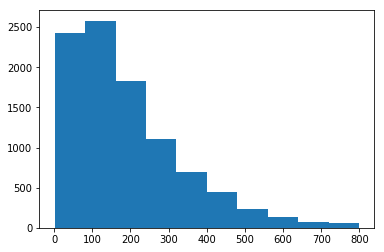

In [14]:
plt.hist(df_crime['crime index'])

In [15]:
# Merge gini index dataframe with crime dataframe using the county_name columns
df = pd.merge(gini_index_df, df_crime, on=['place_state'])
df.shape

(2751, 20)

In [16]:
df.describe()

,Estimate; Gini Index,Margin of Error; Gini Index,crime index,murders,murdersper100k,rapes,rapesper100k,robberies,robberiesper100k,assaults,assaultsper100k,burglaries,burglariesper100k,thefts,theftsper100k,autothefts,autotheftsper100k,arson,arsonper100k
count,2751.000000,2751.000000,2751.000000,2749.000000,2749.000000,2663.00000,2663.000000,2748.000000,2748.000000,2749.000000,2749.000000,2741.000000,2741.000000,2747.000000,2747.000000,2751.000000,2751.000000,2622.000000,2622.000000
mean,0.441798,0.038934,247.381243,1.973445,4.015533,15.21104,47.099925,37.737991,52.413937,93.842852,270.144052,167.684057,532.991281,639.871860,2053.950892,86.920393,161.579571,5.366895,14.257666
std,0.047257,0.022322,151.132935,10.429340,9.474075,62.66576,47.584828,259.676795,75.579349,452.750752,260.759435,669.760268,442.553484,2523.652369,1302.016654,476.398133,163.278605,24.670674,23.340569
min,0.289900,0.001500,2.700000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.409300,0.025200,133.300000,0.000000,0.000000,1.00000,9.350000,0.000000,0.000000,5.000000,92.100000,11.000000,229.300000,48.000000,1067.000000,3.000000,54.800000,0.000000,0.000000
50%,0.441000,0.035600,218.500000,0.000000,0.000000,3.00000,36.500000,2.000000,27.200000,14.000000,190.600000,31.000000,423.200000,129.000000,1822.900000,8.000000,119.500000,1.000000,2.850000
75%,0.470250,0.048000,335.700000,1.000000,3.700000,8.00000,70.000000,9.000000,70.450000,44.000000,367.000000,90.000000,715.300000,380.000000,2789.200000,25.000000,216.850000,2.000000,21.775000
max,0.591300,0.170900,790.000000,269.000000,116.800000,1366.00000,482.400000,9773.000000,1041.100000,14201.000000,2706.100000,17108.000000,4809.100000,67828.000000,8269.900000,11596.000000,2701.900000,665.000000,415.900000


0.00010816181911209122
The distribution of crime index for income inequality existing is not approximately normal.
Positive Skew


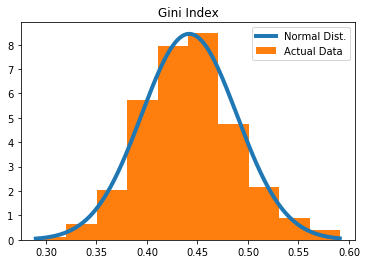

In [17]:
gini = df['Estimate; Gini Index']
# Test to see if the gini index values are normal
st_gini, p_gini = normaltest(gini)
print(p_gini)
if p_gini > 0.01:
    print('The distribution of crime index for income inequality existing is approximately normal.')
else:
    print('The distribution of crime index for income inequality existing is not approximately normal.')
    
xs = np.arange(min(gini), max(gini), 0.001)
fit = stats.norm.pdf(xs, np.mean(gini), np.std(gini))
plt.plot(xs, fit, label = 'Normal Dist.', lw = 4)
plt.hist(gini, density = True, label = 'Actual Data');
plt.title('Gini Index')
plt.legend();

if(statistics.median(gini) < statistics.mean(gini)):
    print('Positive Skew')
else:
    print('Negative Skew')

0.031289184128303095
The distribution of crime index for income inequality existing is approximately normal.
Negative Skew


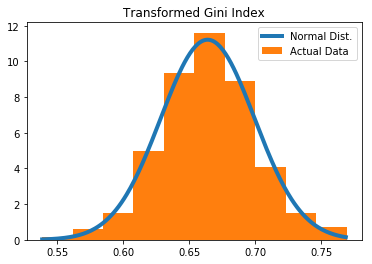

In [18]:
transform_gini = []
for i in range(len(gini)):
    #y = (gini[i]-np.mean(gini))/np.std(gini)
    #y = (gini[i]-min(gini))/(max(gini)-min(gini))
    y = gini[i]**(1/2)
    #y = math.log(gini[i])
    transform_gini.append(y)

st_gini_transform, p_gini_transform = normaltest(transform_gini)
print(p_gini_transform)
if p_gini_transform > 0.01:
    print('The distribution of crime index for income inequality existing is approximately normal.')
else:
    print('The distribution of crime index for income inequality existing is not approximately normal.')
    
xs_transform = np.arange(min(transform_gini), max(transform_gini), 0.001)
fit_transform = stats.norm.pdf(xs_transform, np.mean(transform_gini), np.std(transform_gini))
plt.plot(xs_transform, fit_transform, label = 'Normal Dist.', lw = 4)
plt.hist(transform_gini, density = True, label = 'Actual Data');
plt.title('Transformed Gini Index')
plt.legend();

if(statistics.median(transform_gini) < statistics.mean(transform_gini)):
    print('Positive Skew')
else:
    print('Negative Skew')

df['Transformed_Gini_Index'] = transform_gini

In [19]:
# Find the median gini index and use this to divide the data into two subgroups, with and without income inequality
gini_median = df['Transformed_Gini_Index'].mean()

ineq_exists = [0]*len(df)
for i in range(0,len(df)):
    if df['Transformed_Gini_Index'][i] >= gini_median:
        ineq_exists[i] = 1
    else:
        ineq_exists[i] = 0
        
df['inequality exists'] = ineq_exists

In [20]:
list(df.columns)

['Estimate; Gini Index',
 'Margin of Error; Gini Index',
 'place_state',
 'crime index',
 'murders',
 'murdersper100k',
 'rapes',
 'rapesper100k',
 'robberies',
 'robberiesper100k',
 'assaults',
 'assaultsper100k',
 'burglaries',
 'burglariesper100k',
 'thefts',
 'theftsper100k',
 'autothefts',
 'autotheftsper100k',
 'arson',
 'arsonper100k',
 'Transformed_Gini_Index',
 'inequality exists']

['Estimate; Gini Index',
 'Margin of Error; Gini Index',
 'place_state',
 'crime_index',
 'murders',
 'murdersper100k',
 'rapes',
 'rapesper100k',
 'robberies',
 'robberiesper100k',
 'assaults',
 'assaultsper100k',
 'burglaries',
 'burglariesper100k',
 'thefts',
 'theftsper100k',
 'autothefts',
 'autotheftsper100k',
 'arson',
 'arsonper100k',
 'Transformed_Gini_Index',
 'inequality exists']

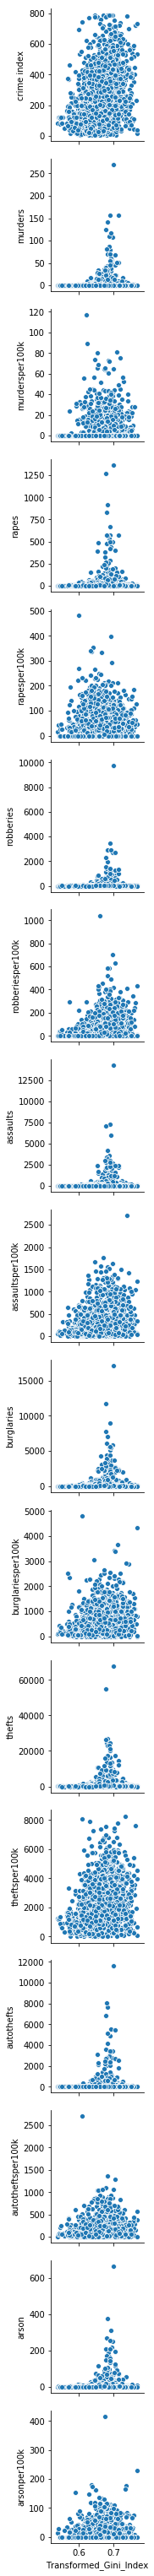

In [21]:
sns.pairplot(df, x_vars = ['Transformed_Gini_Index'],
             y_vars = ['crime index','murders',
 'murdersper100k',
 'rapes',
 'rapesper100k',
 'robberies',
 'robberiesper100k',
 'assaults',
 'assaultsper100k',
 'burglaries',
 'burglariesper100k',
 'thefts',
 'theftsper100k',
 'autothefts',
 'autotheftsper100k',
 'arson',
 'arsonper100k'])
df.rename(columns = {'crime index':'crime_index'}, inplace = True)
list(df.columns)

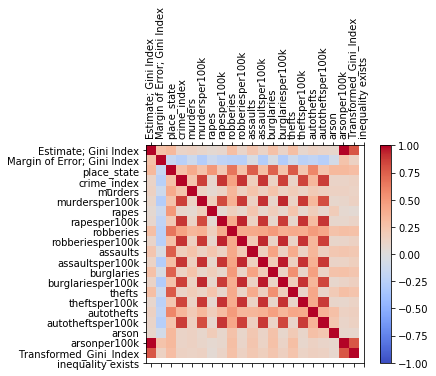

In [22]:
corr = df.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(df.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(df.columns)
ax.set_yticklabels(df.columns)
plt.show()

In [23]:
corr.drop(columns = ['Estimate; Gini Index', 'Margin of Error; Gini Index'], inplace = True)
corr

,crime_index,murders,murdersper100k,rapes,rapesper100k,robberies,robberiesper100k,assaults,assaultsper100k,burglaries,burglariesper100k,thefts,theftsper100k,autothefts,autotheftsper100k,arson,arsonper100k,Transformed_Gini_Index,inequality exists
Estimate; Gini Index,0.321392,0.110286,0.136144,0.097824,0.061381,0.085413,0.283227,0.103652,0.238731,0.119585,0.269081,0.113708,0.283675,0.085617,0.137732,0.103697,0.090372,0.999186,0.783108
Margin of Error; Gini Index,-0.155908,-0.236692,-0.111135,-0.270028,-0.118003,-0.195538,-0.228801,-0.236049,-0.037089,-0.272787,-0.045571,-0.275882,-0.116480,-0.231997,-0.193138,-0.253081,-0.072087,0.254971,0.135864
crime_index,1.000000,0.270454,0.410571,0.250591,0.500200,0.210249,0.659906,0.265675,0.756601,0.284300,0.735070,0.253507,0.772486,0.229376,0.588232,0.246313,0.322228,0.324104,0.289659
murders,0.270454,1.000000,0.246705,0.860170,0.079841,0.893923,0.448109,0.900236,0.167712,0.895871,0.130312,0.859838,0.114198,0.844025,0.333548,0.870223,0.113593,0.112083,0.139317
murdersper100k,0.410571,0.246705,1.000000,0.130964,0.066545,0.124020,0.339095,0.142796,0.256282,0.155213,0.253766,0.126995,0.184211,0.119148,0.198238,0.148510,0.139271,0.137140,0.122809
rapes,0.250591,0.860170,0.130964,1.000000,0.167822,0.831486,0.374706,0.883351,0.136470,0.911200,0.097231,0.934357,0.120793,0.888451,0.326847,0.817275,0.089687,0.100549,0.135690
rapesper100k,0.500200,0.079841,0.066545,0.167822,1.000000,0.060286,0.158686,0.086325,0.234982,0.087128,0.176923,0.086054,0.242296,0.073678,0.177302,0.080048,0.180814,0.064624,0.053575
robberies,0.210249,0.893923,0.124020,0.831486,0.060286,1.000000,0.403635,0.943550,0.129137,0.896414,0.092397,0.877282,0.086321,0.900237,0.301151,0.895577,0.088962,0.086900,0.109837
robberiesper100k,0.659906,0.448109,0.339095,0.374706,0.158686,0.403635,1.000000,0.409651,0.420892,0.434112,0.499062,0.383781,0.412662,0.397315,0.488904,0.427419,0.259959,0.283732,0.265945
assaults,0.265675,0.900236,0.142796,0.883351,0.086325,0.943550,0.409651,1.000000,0.208736,0.934336,0.116700,0.923336,0.116946,0.904925,0.332459,0.863211,0.095493,0.105761,0.137427


In [26]:
onecorr = corr['Transformed_Gini_Index']
sortedcorr = onecorr.sort_values(ascending = False)
sortedcorr

Transformed_Gini_Index         1.000000
Estimate; Gini Index           0.999186
inequality exists              0.783543
crime_index                    0.324104
theftsper100k                  0.286747
robberiesper100k               0.283732
burglariesper100k              0.269145
Margin of Error; Gini Index    0.254971
assaultsper100k                0.239837
autotheftsper100k              0.140563
murdersper100k                 0.137140
burglaries                     0.122088
thefts                         0.116312
murders                        0.112083
arson                          0.105974
assaults                       0.105761
rapes                          0.100549
arsonper100k                   0.091980
autothefts                     0.087791
robberies                      0.086900
rapesper100k                   0.064624
Name: Transformed_Gini_Index, dtype: float64

In [27]:

outcome, predictors = patsy.dmatrices('crime_index ~ Transformed_Gini_Index', df)
mod = sm.OLS(outcome, predictors)
## fit the model
res = mod.fit()

lm = bool(res.pvalues[1] < 0.01)
if lm == True:
    print("Quintile Share significantly predicts crime index.\n")
else:
    print("Quintile Share doesn't significantly predict crime index.\n") 

## look at the results
print(res.summary())

Quintile Share significantly predicts crime index.

                            OLS Regression Results                            
Dep. Variable:            crime_index   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     322.7
Date:                Wed, 12 Jun 2019   Prob (F-statistic):           2.64e-68
Time:                        00:14:51   Log-Likelihood:                -17555.
No. Observations:                2751   AIC:                         3.511e+04
Df Residuals:                    2749   BIC:                         3.513e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

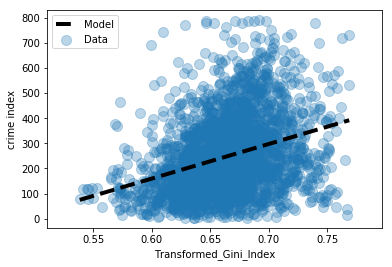

In [28]:
# Plot the orginal data (as before)
plt.scatter(df['Transformed_Gini_Index'], df['crime_index'], alpha=0.3, label='Data', s=100);

# Generate and plot the model fit line
xs = np.linspace(df['Transformed_Gini_Index'].min(), df['Transformed_Gini_Index'].max())
ys = (1376.4454 * xs) - 666.2014 
plt.plot(xs, ys, '--k', linewidth=4, label='Model')

plt.xlabel('Transformed_Gini_Index')
plt.ylabel('crime index')
plt.legend();
plt.show()

1.0110778493075186e-62
The distribution of crime index for income inequality existing is approximately normal.
Negative Skew


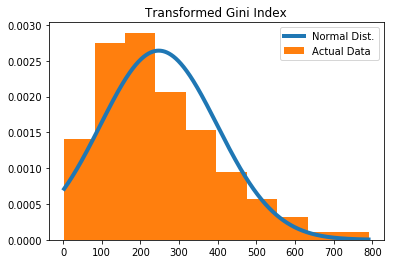

In [29]:
st_crime, p_crime = normaltest(df['crime_index'])
print(p_crime)
if p_gini_transform > 0.01:
    print('The distribution of crime index for income inequality existing is approximately normal.')
else:
    print('The distribution of crime index for income inequality existing is not approximately normal.')
    
xs_crime = np.arange(min(df['crime_index']), max(df['crime_index']), 0.001)
fit_crime = stats.norm.pdf(xs_crime, np.mean(df['crime_index']), np.std(df['crime_index']))
plt.plot(xs_crime, fit_crime, label = 'Normal Dist.', lw = 4)
plt.hist(df['crime_index'], density = True, label = 'Actual Data');
plt.title('Transformed Gini Index')
plt.legend();

if(statistics.median(transform_gini) < statistics.mean(transform_gini)):
    print('Positive Skew')
else:
    print('Negative Skew')

df['Transformed Gini Index'] = transform_gini

In [30]:
corrleation = df[['crime_index', 'Transformed Gini Index']].corr()
corrleation

,crime_index,Transformed Gini Index
crime_index,1.000000,0.324104
Transformed Gini Index,0.324104,1.000000


1383 1368


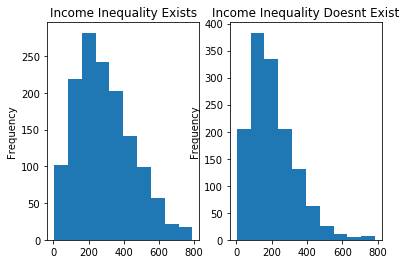

In [31]:
# Side-by-side histogram plots of crime index in areas with and without income inequality
fig, axes = plt.subplots(1, 2)

df[df["inequality exists"] == 1]["crime_index"].plot.hist(ax = axes[0], title = 'Income Inequality Exists')
df[df["inequality exists"] == 0]["crime_index"].plot.hist(ax = axes[1], title = 'Income Inequality Doesn''t Exist')


crime_ineq = df[df["inequality exists"] == 1]["crime_index"].values
crime_no_ineq = df[df["inequality exists"] == 0]["crime_index"].values
print(len(crime_ineq), len(crime_no_ineq))

Negative Skew


(array([  9.,  24.,  63., 165., 282., 335., 262., 161.,  51.,  16.]),
 array([1.39247665, 2.17621706, 2.95995748, 3.74369789, 4.52743831,
        5.31117872, 6.09491913, 6.87865955, 7.66239996, 8.44614038,
        9.22988079]),
 <a list of 10 Patch objects>)

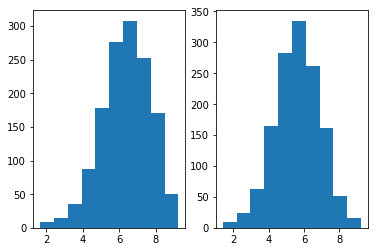

In [32]:
maxine = max(crime_ineq)
minine = min(crime_ineq)

maxnoine = max(crime_no_ineq)
minnoine = min(crime_no_ineq)

stdine = np.std(crime_ineq)
meanine = np.mean(crime_ineq)

stdnoine = np.std(crime_no_ineq)
meannoine = np.mean(crime_no_ineq)

out = []
out1 = []
for j in range(len(crime_ineq)):
    #y = (crime_ineq[j]-minine)/(maxine-minine)
    #y = (crime_ineq[j]-meanine)/stdine
    #if (crime_ineq[j] < 1):
    #    y = 1;
    #else:
    #    y = crime_ineq[j];
    #y = math.log(crime_ineq[j], 2)
    y = crime_ineq[j]**(1/3)
    out.append(y)
    
for k in range(len(crime_no_ineq)):    
    #y1 = (crime_no_ineq[k]-minnoine)/(maxnoine-minnoine)
    #y1 = (crime_no_ineq[k]-meannoine)/stdnoine
    #if (crime_no_ineq[j] < 1):
    #    y1 = 1;
    #else:
    #    y1 = crime_no_ineq[j];
    #y1 = math.log(crime_no_ineq[k], 10)
    y1 = crime_no_ineq[k]**(1/3)
    out1.append(y1)

    
if(statistics.median(out) < statistics.mean(out)):
    print('Positive Skew')
else:
    print('Negative Skew')
    
figz, ax = plt.subplots(1, 2)
ax[0].hist(out)
ax[1].hist(out1)

In [33]:
st_ineq, p_ineq = normaltest(out)
st_no_ineq, p_no_ineq = normaltest(out1)

is_n_ineq = bool(p_ineq > 0.01)
if is_n_ineq == True:
    print('The distribution of crime index for income inequality existing is approximately normal.')
else:
    print('The distribution of crime index for income inequality existing is not approximately normal.')
    
is_n_no_ineq = bool(p_no_ineq > 0.01)
if is_n_no_ineq == True:
    print('The distribution of crime index for income inequality not existing is approximately normal.')
else:
    print('The distribution of crime index for income inequality not existing is not approximately normal.')
    
print(p_ineq, p_no_ineq)

The distribution of crime index for income inequality existing is not approximately normal.
The distribution of crime index for income inequality not existing is approximately normal.
2.8884187775941326e-09 0.03252513230912785
